In [1]:
import numpy as np
import pylab as plt
import torch
import swyft
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
N = 10_000  # Number of samples
Nbins = 100
z = np.random.rand(N, 3)*2 - 1
y = np.linspace(-1, 1, Nbins)
m = np.ones_like(y)*z[:,:1] + y*z[:,1:2] + y**2*z[:,2:]
x = m + np.random.randn(N, Nbins)*0.2 #+ np.random.poisson(lam = 3/Nbins, size = (N, Nbins))*5

# We keep the first sample as observation, and use the rest for training
samples = swyft.Samples(x = x, z = z)
obs = swyft.Sample(samples[0])

In [4]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.summarizer = torch.nn.Linear(Nbins, 3)
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 3, varnames = 'z')

    def forward(self, A, B):
        s = self.summarizer(A['x'])
        s = s.unsqueeze(-1)
        return self.logratios(s, B['z'])

In [5]:
trainer = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64, default_root_dir='/tmp/lightning_logs')
dm = swyft.SwyftDataModule(samples[1:-500])
network = Network()
trainer.fit(network, dm)

GPU available: False, used: False


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/knana/miniforge3/envs/new_env/lib/python3.12/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
Missing logger folder: /tmp/lightning_logs/lightning_logs

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 303   
1 | logratios  | LogRatioEstimator_1dim | 52.2 K
------------------------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params
0.420     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/knana/miniforge3/envs/new_env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/knana/miniforge3/envs/new_env/lib/python3.12/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/knana/miniforge3/envs/new_env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /tmp/lightning_logs/lightning_logs/version_0/checkpoints/epoch=6-step=1666.ckpt


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 238it [00:00, ?it/s]

/Users/knana/miniforge3/envs/new_env/lib/python3.12/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


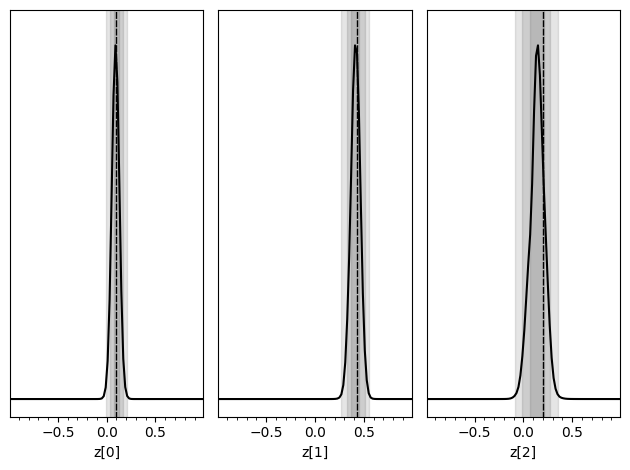

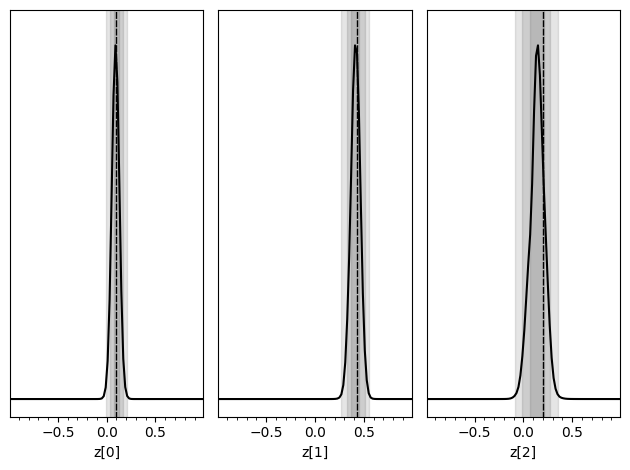

In [6]:
prior_samples = swyft.Samples(z = np.random.rand(10_000, 3)*2-1)
predictions = trainer.infer(network, obs, prior_samples)

truth = {k: v for k, v in zip(["z[%i]"%i for i in range(3)], obs['z'])}
swyft.plot_posterior(predictions, ["z[%i]"%i for i in range(3)], truth=truth)

In [7]:
coverage_samples = trainer.test_coverage(network, samples[-500:], prior_samples)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 238it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 238it [00:00, ?it/s]

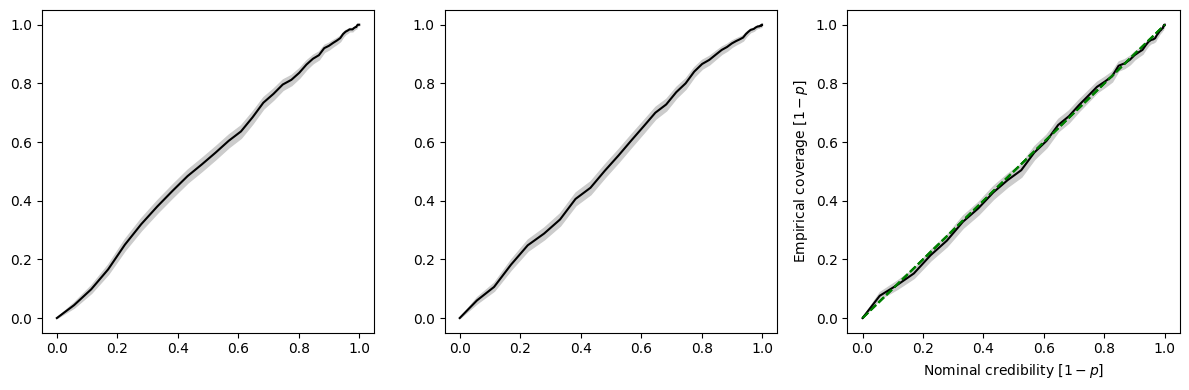

In [8]:
fix, axes = plt.subplots(1, 3, figsize = (12, 4))
for i in range(3):
    swyft.plot_pp(coverage_samples, "z[%i]"%i, ax = axes[i])
plt.tight_layout()

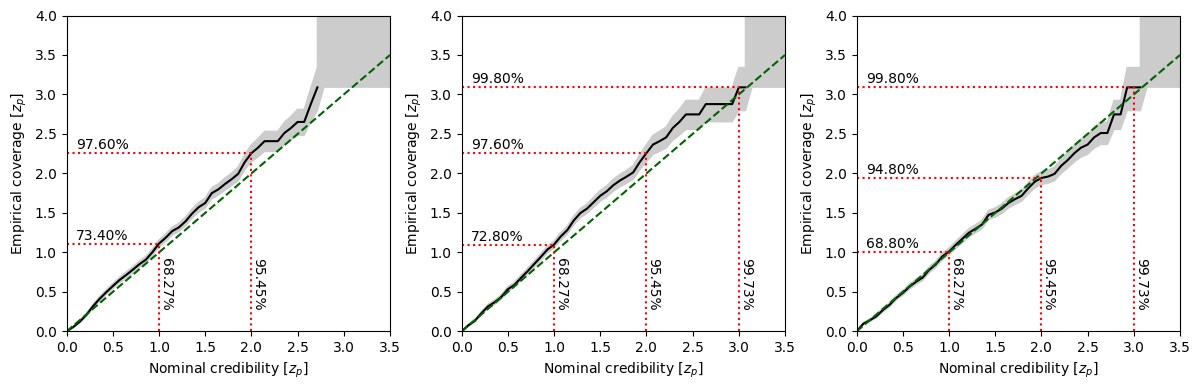

In [9]:
fix, axes = plt.subplots(1, 3, figsize = (12, 4))
for i in range(3):
    swyft.plot_zz(coverage_samples, "z[%i]"%i, ax = axes[i])
plt.tight_layout()